In [1]:
import numpy as np
import pandas as pd

## Passo 1: Leitura dos dados
Leitura dos bancos de dados em DataFrame Pandas. 

In [2]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [3]:
df = pd.read_csv(caminho_dados_lazaro)

In [4]:
df.head()

,Piquete,Altura real,Altura esperada,Animal,SensorID,Sensor Name,Date,X,Y,Z,Comportamento,Season_fall,Season_spring,Season_summer,magn,sma,ent,pit,rol,icl
0,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:47,-0.132,-0.583,0.712,Ocio,0.0,1.0,0.0,0.929654,1.427,-0.005973,8.162915,129.311311,40.014999
1,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:48,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
2,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:50,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
3,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:51,0.021,-0.792,0.574,Ocio,0.0,1.0,0.0,0.978356,1.387,-0.282943,-1.229924,144.067373,54.076939
4,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 09:47:52,-0.061,-0.870,0.478,Ocio,0.0,1.0,0.0,0.994538,1.409,-0.361029,3.516446,151.214493,61.273746


In [5]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

## Passo 2: Treinamento

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Para a busca do melhores hiperparêmetros
from sklearn.model_selection import RandomizedSearchCV

### Seleção de colunas aplicáveis

In [19]:
df.columns

Index(['X', 'Y', 'Z', 'Comportamento', 'Season_fall', 'Season_spring',
       'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl'],
      dtype='object')

In [18]:
df.dtypes

X                float32
Y                float32
Z                float32
Comportamento     object
Season_fall      float32
Season_spring    float32
Season_summer    float32
magn             float32
sma              float32
ent              float32
pit              float32
rol              float32
icl              float32
dtype: object

In [17]:
# Converte colunas float 64 para float 32, assim é possível usar GPU
float64_cols = [cname for cname in df.columns if df[cname].dtype in ['float64']]

df[float64_cols] = df[float64_cols].astype('float32')

In [20]:
# Lista com os atributos aplicáveis
features_aplicaveis = ['X', 'Y' ,'Z', 'Comportamento', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']

# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [21]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
# Test size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [12]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')
X_train, X_test, y_train, y_test = train_test_split(X, y_pnp, random_state = 0)

### Função para imprimir e salvar matriz de confusão

In [22]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.0%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [ ]:
from cuml import RandomForestClassifier as cuRF

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

y_train = enc.fit_transform(y_train.array.reshape(-1, 1))

y_test = enc.transform(y_test.array.reshape(-1, 1))

In [32]:
# cuml Random Forest params
cu_rf_params = {
    'n_estimators': 200,
    'max_depth': 50,
    'n_bins': 15,
    'n_streams': 32 }

cu_rf = cuRF(**cu_rf_params)
cu_rf.fit(X_train, y_train)
rf_preds = cu_rf.predict(X_test)

print("cuml RF Accuracy Score: ", accuracy_score(rf_preds, y_test))

cuml RF Accuracy Score:  0.7231533454555037


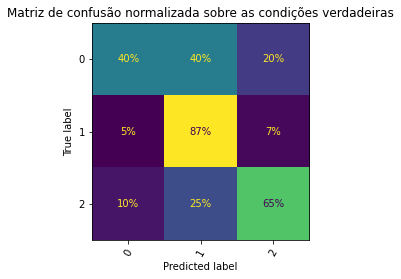

In [33]:
imprimeMatrizDeConfusão(y_test, rf_preds, cu_rf, salvarFigura = False)

In [31]:
gpu

NameError: name 'gpu' is not defined